# English-French Translation Using Transformers
SAARANG ARORA

This notebook builds a basic **Encoder-Decoder** variant of the Transformer architecture from scratch (Multi-Head Attention, Scaled Dot-Product Attention and Causal Masking included) in TensorFlow.

It serves to understand how each part of the Transformer works and how they all fit together.

The Transformer is then tested on a simple seq2seq task : **translating sentences from English to French**.

In [1]:
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import string
import re
import numpy as np

In [ ]:
print(f"Tensor Flow Version: {tf.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "AVAILABLE" if gpu else "NOT AVAILABLE")

# Preparing the data

In [ ]:
file_path = '/kaggle/input/eng_-french.csv'

# read the data
df = pd.read_csv(file_path)
df_1 = pd.read_csv(file_path)
df['source'] = df['English words/sentences']

# let's add an initial “seed” token ([start]) and a stop token ([end]) to each target sentence.
df['target'] = df['French words/sentences'].apply(lambda x: '[start] ' + x + ' [end]')
df = df.drop(['English words/sentences', 'French words/sentences'], axis=1)

# display a few random samples
df.sample(5)

,source,target
46827,He gave me some stamps.,[start] Il m'a donné des timbres. [end]
33549,Did anybody get hurt?,[start] Quiconque a-t-il été blessé ? [end]
151325,Are these the glasses you were looking for?,[start] Sont-ce les lunettes que vous cherchie...
168862,There are too many people here. Let's go somew...,"[start] Il y a trop de gens ici, changeons d'e..."
127004,This river is the widest in Europe.,[start] Ce fleuve est le plus large d'Europe. ...


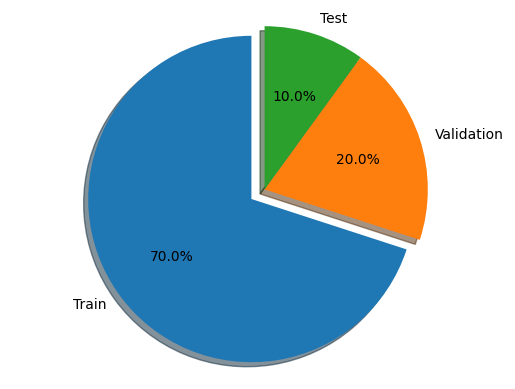

In [6]:
# shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

# split the data into train, validation, and test sets
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.2)
test_size = int(len(df) * 0.1)

train_df = df[:train_size]
val_df = df[train_size:train_size+val_size]
test_df = df[train_size+val_size:]

# display the data sets representations using a pie chart just to see the distribution of the data
labels = 'Train', 'Validation', 'Test'
sizes = [len(train_df), len(val_df), len(test_df)]
explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


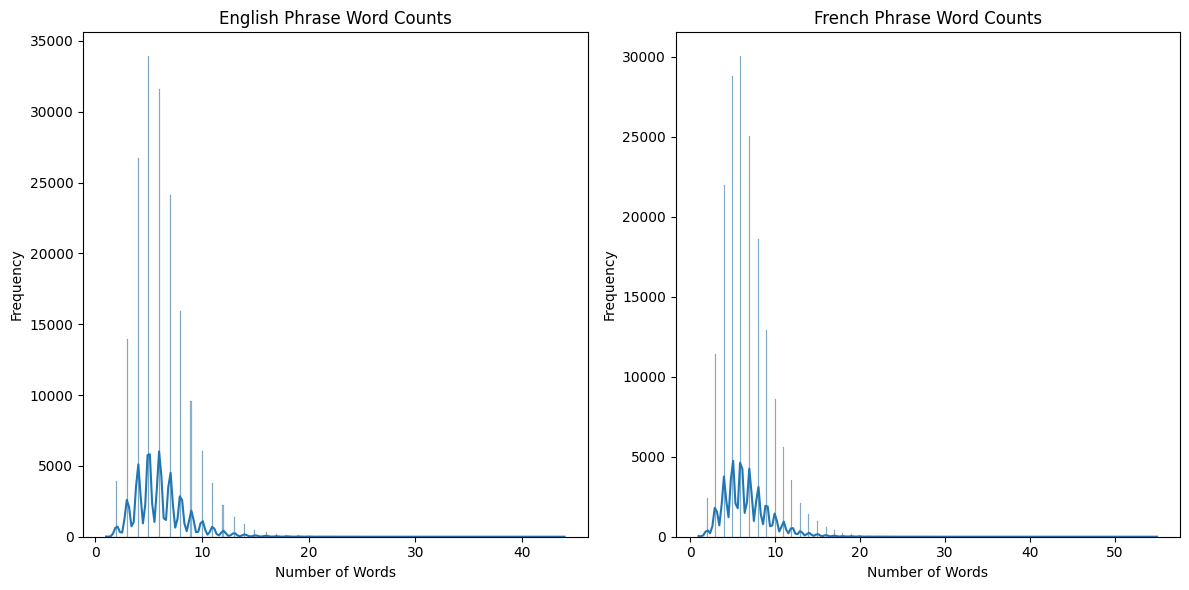

English Phrase Word Count Statistics:
count    175621.000000
mean          6.161552
std           2.485664
min           1.000000
25%           4.000000
50%           6.000000
75%           7.000000
max          44.000000
Name: english_word_count, dtype: float64

French Phrase Word Count Statistics:
count    175621.000000
mean          6.706669
std           2.789074
min           1.000000
25%           5.000000
50%           6.000000
75%           8.000000
max          55.000000
Name: french_word_count, dtype: float64


In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def plot_phrase_word_count_comparison(df, english_col, french_col):

    # Calculate word counts
    df_1['english_word_count'] = df_1[english_col].str.split().str.len()
    df_1['french_word_count'] = df_1[french_col].str.split().str.len()
    
    # Create the figure and axes
    plt.figure(figsize=(12, 6))
    
    # English phrase word count histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data=df_1, x='english_word_count', kde=True)
    plt.title('English Phrase Word Counts')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    
    # French phrase word count histogram
    plt.subplot(1, 2, 2)
    sns.histplot(data=df_1, x='french_word_count', kde=True)
    plt.title('French Phrase Word Counts')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
    
    # Print basic statistics
    print("English Phrase Word Count Statistics:")
    print(df_1['english_word_count'].describe())
    print("\nFrench Phrase Word Count Statistics:")
    print(df_1['french_word_count'].describe())

# Example usage
plot_phrase_word_count_comparison(df, 'English words/sentences', 'French words/sentences')

Here we can see the distribution of the number of phrases that are there. There are long phrases (ENG: 44 words | FR: 55 Words) and short phrases, but the mean lies somewhere near the lower end (ENG: 6.1 words | FR: 6.7 Words)

In [8]:
max_tokens = 25000
sequence_length = 30

# define a custom standardization function that convert to lowercase and strips all punctuations except "[" and "]" (so we can tell apart "start" from "[start]").
strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
 
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

# tokenize the data using our custom standardization function
source_vectorization = keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=sequence_length + 1, # add +1 token to our target sentences since they'll be shifted right by 1 during training
    standardize=custom_standardization,
)

# index all tokens in the source and target sentences
train_source_texts = train_df['source'].values
train_target_texts = train_df['target'].values
source_vectorization.adapt(train_source_texts)
target_vectorization.adapt(train_target_texts)

In [9]:
# display a random sample before and after vectorization just to test the vectorization
random_sample = random.randint(0, len(train_df))
print("Source texts (one random sample):", train_source_texts[random_sample])
print("Target texts (one random sample):", train_target_texts[random_sample])
print("Source vectors (one random sample):", source_vectorization(train_source_texts[random_sample]))
print("Target vectors (one random sample):", target_vectorization(train_target_texts[random_sample]))

# display the decoding of the vectorized text (from vector back to text) just to test the vectorization
source_decoded_text = ''
for i in range(len(source_vectorization(train_source_texts[random_sample]))):
    source_decoded_text += source_vectorization.get_vocabulary()[source_vectorization(train_source_texts[random_sample])[i]] + ' '
print("Source decoded texts (one random sample):", source_decoded_text)

target_decoded_text = ''
for i in range(len(target_vectorization(train_target_texts[random_sample]))):
    target_decoded_text += target_vectorization.get_vocabulary()[target_vectorization(train_target_texts[random_sample])[i]] + ' '
print("Target decoded texts (one random sample):", target_decoded_text)

Source texts (one random sample): Tom didn't have anything to say.
Target texts (one random sample): [start] Tom n'avait rien à dire. [end]
Source vectors (one random sample): tf.Tensor(
[  8  54  17 124   4 117   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0], shape=(30,), dtype=int64)
Target vectors (one random sample): tf.Tensor(
[  2  14 637  92   9  81   3   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(31,), dtype=int64)
Source decoded texts (one random sample): tom didnt have anything to say                         
Target decoded texts (one random sample): [start] tom navait rien à dire [end]                         


In [10]:
# display the shape of our vectorized data
train_source_vectors = source_vectorization(train_source_texts)
train_target_vectors = target_vectorization(train_target_texts)
print("Source vectors (shape):", train_source_vectors.shape)
print("Target vectors (shape):", train_target_vectors.shape)

Source vectors (shape): (122934, 30)
Target vectors (shape): (122934, 31)


# Building the Transformer

In order for our Transformer to be aware of the word order in each sentence, we must add some positional information to the data. **Words must become position-aware.**

First, each token in our vectors will be embedded in a low-dimensional vector (the dimensionality of the embedding space is defined by the **embedding_size** parameter).

Secondly, position information (info on where each word stands in the sentence) will be created and added to the embeddings.

This will result in a batch of vectors of positional embeddings, stored in a **3D** matrix of shape [(batch_size, sequence_length, **embedding_size**)].

In [11]:
class PositionalEmbedding(keras.layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = keras.layers.Embedding(input_dim=input_dim, output_dim=output_dim) # token embedding layer
        self.position_embeddings = keras.layers.Embedding(input_dim=sequence_length, output_dim=output_dim) # position embedding layer
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        embedded_tokens = self.token_embeddings(inputs) # embed the tokens
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1) # create the positional information
        embedded_positions = self.position_embeddings(positions) # embed the positions 
        return embedded_tokens + embedded_positions # add the token and position embeddings to create the positional embeddings

    def compute_mask(self, inputs, mask=None):
        return keras.ops.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "input_dim": self.input_dim,
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
        })
        return config

In [12]:
# display a random sample before and after embbeding just to test our class

embed_dim = 256

with tf.device('cpu:0'):
    train_source_embedded = PositionalEmbedding(
        sequence_length=sequence_length,
        input_dim=max_tokens,
        output_dim=embed_dim,
        name="source_embedding",
    ) (train_source_vectors)

    train_target_embedded = PositionalEmbedding(
        sequence_length=sequence_length,
        input_dim=max_tokens,
        output_dim=embed_dim,
        name="target_embedding",
    ) (train_source_vectors)

    random_sample = random.randint(0, len(train_df))
    print("Source texts (one random sample):", train_source_texts[random_sample])
    print("Target texts (one random sample):", train_target_texts[random_sample])
    print("Source vectors (one random sample):", source_vectorization(train_source_texts[random_sample]))
    print("Target vectors (one random sample):", target_vectorization(train_target_texts[random_sample]))
    print("Source embedded vectors (one random sample):", train_source_embedded[random_sample])
    print("Target embedded vectors (one random sample):", train_target_embedded[random_sample])

Source texts (one random sample): Someone has stolen all my money.
Target texts (one random sample): [start] Quelqu'un m'a volé tout mon argent. [end]
Source vectors (one random sample): tf.Tensor(
[ 291   69 1106   38   20  111    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(30,), dtype=int64)
Target vectors (one random sample): tf.Tensor(
[  2 169  38 829  35  40 570   3   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(31,), dtype=int64)
Source embedded vectors (one random sample): tf.Tensor(
[[ 0.00278613 -0.02166479  0.03063967 ... -0.01911527  0.01324068
  -0.00889528]
 [ 0.09107338 -0.05875959 -0.04864768 ...  0.05645386 -0.04480252
   0.0147324 ]
 [ 0.01359802  0.0148865  -0.04385047 ... -0.04492656 -0.0611102
   0.06977727]
 ...
 [-0.0313083  -0.04291035  0.01042945 ...  0.04234681 -0.01322633
   0.02792252]
 [-0.04395533 -0.05949598  0.0536456

In [13]:
# display the shape of our embedded data just to test the class
print("Source embedded vectors (shape):", train_source_embedded.shape)
print("Target embedded vectors (shape):", train_target_embedded.shape)

Source embedded vectors (shape): (122934, 30, 256)
Target embedded vectors (shape): (122934, 30, 256)


The goal here is to make each of our words (positional embeddings at this point) aware of the other words surrounding them. **Words must become context-aware.**

The implementation of the Attention mechanism involves the following 3 steps : 

- Causal Masking
- Scaled Dot-Product Attention
- Multi-Head Attention

In practice, we could just use **keras.layers.MultiHeadAttention** instead of building it from scratch, but let's do it anyway! 😒

In [14]:
# credits to OpenAI for that one (https://github.com/openai/gpt-2/blob/master/src/model.py)

def shape_list(x):
    """Deal with dynamic shape in tensorflow cleanly."""
    static = x.shape.as_list()
    dynamic = tf.shape(x)
    return [dynamic[i] if s is None else s for i, s in enumerate(static)]

def attention_mask(nd, ns, *, dtype):
    """1's in the lower triangle, counting from the lower right corner.
    Same as tf.matrix_band_part(tf.ones([nd, ns]), -1, ns-nd), but doesn't produce garbage on TPUs.
    """
    i = tf.range(nd)[:,None]
    j = tf.range(ns)
    m = i >= j - ns + nd
    return tf.cast(m, dtype)

def mask_attn_weights(w):
    # w has shape [batch, heads, dst_sequence, src_sequence], where information flows from src to dst.
    _, _, nd, ns = shape_list(w)
    b = attention_mask(nd, ns, dtype=w.dtype)
    b = tf.reshape(b, [1, 1, nd, ns])
    w = w*b - tf.cast(1e10, w.dtype)*(1-b)
    return w

In [15]:
# display the causal masking of a random tensor just to test the function
random_tensor = tf.random.uniform(shape=(1, 1, 5, 5), minval=0, maxval=1, dtype=tf.float32)
print("Masked attention weights:", mask_attn_weights(random_tensor))

Masked attention weights: tf.Tensor(
[[[[ 6.5683436e-01 -1.0000000e+10 -1.0000000e+10 -1.0000000e+10
    -1.0000000e+10]
   [ 8.5074067e-02  8.2758307e-01 -1.0000000e+10 -1.0000000e+10
    -1.0000000e+10]
   [ 1.5143049e-01  6.9662786e-01  8.4872127e-01 -1.0000000e+10
    -1.0000000e+10]
   [ 6.8169045e-01  3.6201596e-02  2.0449567e-01  4.0634751e-02
    -1.0000000e+10]
   [ 2.2109389e-01  5.3467178e-01  7.7757633e-01  2.8936183e-01
     8.8333857e-01]]]], shape=(1, 1, 5, 5), dtype=float32)


In [16]:
def scaled_dot_product_attention(q, k, v, use_causal_mask=False):
    d_k = tf.cast(tf.shape(k)[-1], tf.float32)
    scores = tf.matmul(q, k, transpose_b=True) # Matmul of Q and K
    scaled_scores = scores / tf.math.sqrt(d_k) # Scale
    if use_causal_mask:
        scaled_scores = mask_attn_weights(scaled_scores) # Mask (opt.)
    weights = tf.nn.softmax(scaled_scores, axis=-1) # SoftMax
    output = tf.matmul(weights, v) # Matmul of SoftMax and V
    return output

In [17]:
# display the shape of our attention output just to test the function
with tf.device('cpu:0'):
    input = train_source_embedded
    input = tf.expand_dims(input, axis=1)
    print("Scaled dot product attention (shape):", scaled_dot_product_attention(input, input, input, use_causal_mask=True).shape)

Scaled dot product attention (shape): (122934, 1, 30, 256)


In [18]:
class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, embed_dim, h, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.h = h
        if embed_dim % h != 0:
            raise ValueError(
                f"dimension of the embedding space = {embed_dim} should be divisible by number of heads = {h}"
            )
        self.q_linear = keras.layers.Dense(embed_dim)
        self.k_linear = keras.layers.Dense(embed_dim)
        self.v_linear = keras.layers.Dense(embed_dim)
        self.concat_linear = keras.layers.Dense(embed_dim)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, shape=(batch_size, -1, self.h, self.embed_dim // self.h))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def concat_heads(self, x, batch_size):
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        return tf.reshape(x, (batch_size, -1, self.embed_dim))

    def call(self, q, k, v, use_causal_mask=False):
        batch_size = tf.shape(k)[0]
        q = self.q_linear(q)
        k = self.k_linear(k)
        v = self.v_linear(v)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        attention = scaled_dot_product_attention(q, k, v, use_causal_mask)
        concat = self.concat_heads(attention, batch_size)
        concat = self.concat_linear(concat)
        return concat

    def get_config(self):
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "h": self.h,
        })
        return config

In [19]:
class TransformerEncoder(keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.layer_norm_1 = keras.layers.LayerNormalization()
        self.layer_norm_2 = keras.layers.LayerNormalization()
        self.global_self_attention = MultiHeadAttention(embed_dim=embed_dim, h=num_heads)
        self.feed_forward = keras.Sequential(
            [keras.layers.Dense(dense_dim, activation="relu"),
             keras.layers.Dense(embed_dim),]
        )
        
    def call(self, x):
        # Post layer normalization + residual connections
        x = self.layer_norm_1(x + self.global_self_attention(q=x, k=x, v=x))
        x = self.layer_norm_2(x + self.feed_forward(x))
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config

In [20]:
class TransformerDecoder(keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.causal_self_attention = MultiHeadAttention(embed_dim=embed_dim, h=num_heads)
        self.cross_attention = MultiHeadAttention(embed_dim=embed_dim, h=num_heads)
        self.feed_forward = keras.Sequential(
            [keras.layers.Dense(dense_dim, activation="relu"),
             keras.layers.Dense(embed_dim),]
        )
        self.layer_norm_1 = keras.layers.LayerNormalization()
        self.layer_norm_2 = keras.layers.LayerNormalization()
        self.layer_norm_3 = keras.layers.LayerNormalization()

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config

    def call(self, x, context):
        # Post layer normalization + residual connections
        x = self.layer_norm_1(x + self.causal_self_attention(q=x, k=x, v=x, use_causal_mask=True))
        x = self.layer_norm_2(x + self.cross_attention(q=x, k=context, v=context))
        x = self.layer_norm_3(x + self.feed_forward(x))
        return x

In [21]:
batch_size = 256

def format_dataset(source, target):
    source_vectors = source_vectorization(source)
    target_vectors = target_vectorization(target)
    return ({
        "source": source_vectors, # encoder_inputs
        "target": target_vectors[:, :-1], # decoder_inputs (truncate by 1 to keep it at the same length as decoder_outputs, which is shifted right by 1).
    }, target_vectors[:, 1:]) # decoder_outputs

def make_dataset(df):
    dataset = tf.data.Dataset.from_tensor_slices((df["source"].values, df["target"].values))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_df)
val_ds = make_dataset(val_df)

In [22]:
# display the shape of the first batch of data in the dataset just to see what it looks like
for batch in train_ds.take(1):
    print("Encoder Inputs:", batch[0]["source"].shape)
    print("Decoder Inputs:", batch[0]["target"].shape)
    print("Decoder Outputs:", batch[1].shape)

Encoder Inputs: (256, 30)
Decoder Inputs: (256, 30)
Decoder Outputs: (256, 30)


In [23]:
embed_dim = 512 # dimension of the embedding space
dense_dim = 2048 # dimension of the feed forward network (a rule of thumb is to use 4 times the size of the embeddings)
num_heads = 8

# the transformer body
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="source")
x = PositionalEmbedding(sequence_length, max_tokens, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="target")
x = PositionalEmbedding(sequence_length, max_tokens, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)

# the transformer head
x = keras.layers.Dropout(0.5)(x)
decoder_outputs = keras.layers.Dense(max_tokens, activation="softmax")(x)

transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'transformer_encoder' (of type TransformerEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'transformer_decoder' (of type TransformerDecoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


# Training the Transformer

In [24]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

EPOCHS = 30
checkpoint_filepath = '/tmp/checkpoint.weights.h5'
callbacks_list = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=6,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    ),
]
    
transformer.fit(train_ds, 
                epochs=EPOCHS, 
                callbacks=callbacks_list,
                validation_data=val_ds)

transformer.load_weights(checkpoint_filepath)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'multi_head_attention' (of type MultiHeadAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'multi_head_attention_1' (of type MultiHeadAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
I0000 00:00:1736925183.147185      65 service.cc:145] XLA service 0x7fe98c004260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736925183.147243      65 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:17369

297/481 ━━━━━━━━━━━━━━━━━━━━ 39s 215ms/step - accuracy: 0.7679 - loss: 2.0632

W0000 00:00:1736925255.748619      65 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.7799 - loss: 1.8250

W0000 00:00:1736925300.265256      67 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1736925305.511783      66 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


481/481 ━━━━━━━━━━━━━━━━━━━━ 132s 247ms/step - accuracy: 0.7799 - loss: 1.8241 - val_accuracy: 0.8152 - val_loss: 1.1227 - learning_rate: 0.0010
Epoch 2/30
481/481 ━━━━━━━━━━━━━━━━━━━━ 108s 225ms/step - accuracy: 0.8133 - loss: 1.1435 - val_accuracy: 0.8204 - val_loss: 1.0430 - learning_rate: 0.0010
Epoch 3/30
481/481 ━━━━━━━━━━━━━━━━━━━━ 107s 223ms/step - accuracy: 0.8239 - loss: 1.0374 - val_accuracy: 0.8696 - val_loss: 0.7561 - learning_rate: 0.0010
Epoch 4/30
481/481 ━━━━━━━━━━━━━━━━━━━━ 105s 219ms/step - accuracy: 0.8716 - loss: 0.7543 - val_accuracy: 0.9014 - val_loss: 0.5506 - learning_rate: 0.0010
Epoch 5/30
481/481 ━━━━━━━━━━━━━━━━━━━━ 105s 218ms/step - accuracy: 0.8991 - loss: 0.5705 - val_accuracy: 0.9113 - val_loss: 0.4805 - learning_rate: 0.0010
Epoch 6/30
481/481 ━━━━━━━━━━━━━━━━━━━━ 105s 218ms/step - accuracy: 0.9143 - loss: 0.4581 - val_accuracy: 0.9172 - val_loss: 0.4377 - learning_rate: 0.0010
Epoch 7/30
481/481 ━━━━━━━━━━━━━━━━━━━━ 104s 217ms/step - accuracy: 0.9227 

# Testing the Transformer

Let's translate a few random test sentences with our newly-trained Transformer.

In [25]:
target_vocab = target_vectorization.get_vocabulary()
target_index_lookup = dict(zip(range(len(target_vocab)), target_vocab))
max_decoded_sentence_length = 30

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = target_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

# let's translate 5 random sentences
for i in range(5):
    random_index = np.random.randint(0, len(test_df))
    input_sentence = test_df["source"].iloc[random_index]
    print(input_sentence)
    print(decode_sequence(input_sentence))
    print()

Tom isn't joking.
[start] tom ne blague pas [end]

I overslept again.
[start] jai encore trop entendu [end]

We'll all be there together.
[start] nous serons tous ensemble [end]

Spare me the grisly details.
[start] qui me trouve les détails [end]

Our car ran out of gas after ten minutes.
[start] notre voiture a couru dehors après dix minutes de dix minutes [end]

